<a href="https://colab.research.google.com/github/aseelalzaben03/Video-classification--1/blob/main/Video_classification_shop_lifters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Load and Display data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import os
import cv2
from IPython.display import Video, display

In [ ]:
# Define the path to your video folder
video_folder_path = '/content/drive/My Drive/ShopDataSet/'

# List all video files in the folder
video_files = [f for f in os.listdir(video_folder_path) if f.endswith(('.mp4', '.avi', '.mov'))]


In [ ]:
shop_filters_path = '/content/drive/My Drive/ShopDataSet/shop_lifters/'
non_shop_filters_path = '/content/drive/My Drive/ShopDataSet/nonshop_lifters/'

In [ ]:
# List all video files in the "shop lifters" folder
shop_video_files = [f for f in os.listdir(shop_filters_path) if f.endswith(('.mp4', '.avi', '.mov'))]
# List all video files in the "non shop lifters" folder
non_shop_video_files = [f for f in os.listdir(non_shop_filters_path) if f.endswith(('.mp4', '.avi', '.mov'))]
print(f' Shop video file contain :{len(shop_video_files)}')
print(f'Non shop video file contain :{len(non_shop_video_files)}')

 Shop video file contain :324
Non shop video file contain :531


In [ ]:
# Select one video file from each folder
selected_shop_video = shop_video_files[0]
selected_non_shop_video = non_shop_video_files[6]
# Create full paths for the selected videos
shop_video_path = os.path.join(shop_filters_path, selected_shop_video)
non_shop_video_path = os.path.join(non_shop_filters_path, selected_non_shop_video)

In [ ]:
# Display the selected videos with fixed dimensions
print(f"Showing shop filter video: {shop_video_path}")
display(Video(shop_video_path, embed=True , width=320, height=240))



Showing shop filter video: /content/drive/My Drive/ShopDataSet/shop_lifters/videppppsss_0.mp4


In [ ]:
print(f"Showing non-shop filter video: {non_shop_video_path}")
display(Video(non_shop_video_path,embed=True, width=320, height=240))

Showing non-shop filter video: /content/drive/My Drive/ShopDataSet/nonshop_lifters/videossssstttsss_54.mp4


## Spliting the data

In [ ]:
datase='/content/drive/My Drive/ShopDataSet/split_dataset/'

## Preprocessing

In [ ]:
import os
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models
import cv2
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import random


In [ ]:
# Configuration parameters
FRAME_COUNT = 30  # Fixed number of frames to extract from each video
IMG_HEIGHT = 128  # Resize height
IMG_WIDTH = 128   # Resize width
BATCH_SIZE = 32
EPOCHS = 100
LEARNING_RATE = 0.0001


In [ ]:
# Paths
DATASET_PATH = "/content/drive/MyDrive/split_dataset"
TRAIN_PATH ="/content/drive/MyDrive/split_dataset/train"
VAL_PATH = "/content/drive/MyDrive/split_dataset/val"
TEST_PATH = "/content/drive/MyDrive/split_dataset/test"


In [ ]:
def extract_frames(video_path):
    print(f"  Opening video: {video_path}")
    frames = []
    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        print(f"  Error: Could not open video {video_path}")
        return None

    # Get total frames in video
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print(f"  Total frames in video: {total_frames}")

    if total_frames <= 0:
        print(f"  Error: No frames detected in video {video_path}")
        return None

    # Calculate step size to get exactly FRAME_COUNT frames
    step = max(total_frames // FRAME_COUNT, 1)

    frame_indices = list(range(0, min(total_frames, step * FRAME_COUNT), step))
    if len(frame_indices) > FRAME_COUNT:
        frame_indices = frame_indices[:FRAME_COUNT]

    # Pad with last frame if needed
    while len(frame_indices) < FRAME_COUNT:
        frame_indices.append(total_frames - 1)

    for idx in frame_indices:
        cap.set(cv2.CAP_PROP_POS_FRAMES, idx)
        ret, frame = cap.read()
        if not ret:
            continue

        # Convert BGR to RGB
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

        # Resize frame
        frame = cv2.resize(frame, (IMG_WIDTH, IMG_HEIGHT))

        # Normalize pixel values to [0,1]
        frame = frame / 255.0

        frames.append(frame)

    cap.release()

    # Ensure we have exactly FRAME_COUNT frames
    if len(frames) != FRAME_COUNT:
        return None

    return np.array(frames)


In [ ]:
import os
import numpy as np
def load_dataset_paths(dataset_path):
    video_paths = []
    labels = []

    # Add paths for shop videos
    shop_dir = os.path.join(dataset_path, "shop_lifters")
    if os.path.exists(shop_dir):
        for video_file in os.listdir(shop_dir):
            if video_file.endswith(('.mp4', '.avi', '.mov')):
                video_paths.append(os.path.join(shop_dir, video_file))
                labels.append(1)

    # Add paths for nonshop videos
    nonshop_dir = os.path.join(dataset_path, "nonshop_lifters")
    if os.path.exists(nonshop_dir):
        for video_file in os.listdir(nonshop_dir):
            if video_file.endswith(('.mp4', '.avi', '.mov')):
                video_paths.append(os.path.join(nonshop_dir, video_file))
                labels.append(0)

    return video_paths, labels

In [ ]:
# Data augmentation for training samples
def augment_video(frames):
    augmented_frames = []

    for frame in frames:
        # Random brightness adjustment
        if random.random() > 0.5:
            brightness = random.uniform(0.8, 1.2)
            frame = np.clip(frame * brightness, 0, 1)

        # Random horizontal flip
        if random.random() > 0.5:
            frame = np.fliplr(frame)

        augmented_frames.append(frame)

    return np.array(augmented_frames)

## Modeling

In [ ]:
# Build the 3D CNN model
def build_model():
    model = models.Sequential([
        # First Conv3D block
        layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu', padding='same',
                     input_shape=(FRAME_COUNT, IMG_HEIGHT, IMG_WIDTH, 3)),
        layers.MaxPooling3D(pool_size=(1, 2, 2)),
        layers.BatchNormalization(),

        # Second Conv3D block
        layers.Conv3D(64, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(1, 2, 2)),
        layers.BatchNormalization(),

        # Third Conv3D block
        layers.Conv3D(128, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(1, 2, 2)),
        layers.BatchNormalization(),

        # Fourth Conv3D block
        layers.Conv3D(256, kernel_size=(3, 3, 3), activation='relu', padding='same'),
        layers.MaxPooling3D(pool_size=(2, 2, 2)),
        layers.BatchNormalization(),

        # Flatten and Dense layers
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')  # Binary classification
    ])

    return model

In [ ]:
# Custom data generator to save memory
def video_data_generator(file_paths, labels, batch_size ,augment=False):
    num_samples = len(file_paths)
    while True:
        indices = np.random.permutation(num_samples)
        for start_idx in range(0, num_samples, batch_size):
            batch_indices = indices[start_idx:min(start_idx + batch_size, num_samples)]
            batch_videos = []
            batch_labels = []

            for idx in batch_indices:
                frames = extract_frames(file_paths[idx])
                if frames is not None:
                    batch_videos.append(frames)
                    batch_labels.append(labels[idx])

            yield np.array(batch_videos), np.array(batch_labels)

In [ ]:
# Main execution
print("Loading training data...")
train_videos, train_labels = load_dataset_paths(TRAIN_PATH)
print(f"Loaded {len(train_videos)} training videos")

Loading training data...
Loaded 719 training videos


In [ ]:

print("Loading validation data...")
val_videos, val_labels = load_dataset_paths(VAL_PATH)
print(f"Loaded {len(val_videos)} validation videos")

Loading validation data...
Loaded 307 validation videos


In [ ]:
# Create data generators
train_gen = video_data_generator(train_videos, train_labels, 16 , augment=True )
val_gen = video_data_generator(val_videos, val_labels, 16, augment=False)


In [ ]:
# Build and compile the model
model = build_model()
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv3d (Conv3D)                      │ (None, 30, 128, 128, 32)    │           2,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d (MaxPooling3D)         │ (None, 30, 64, 64, 32)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 30, 64, 64, 32)      │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_1 (Conv3D)                    │ (None, 30, 64, 64, 64)      │          55,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_1 (MaxPooling3D)       │ (None, 30, 32, 32, 64)      │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 30, 32, 32, 64)      │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_2 (Conv3D)                    │ (None, 30, 32, 32, 128)     │         221,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_2 (MaxPooling3D)       │ (None, 30, 16, 16, 128)     │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 30, 16, 16, 128)     │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv3d_3 (Conv3D)                    │ (None, 30, 16, 16, 256)     │         884,992 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling3d_3 (MaxPooling3D)       │ (None, 15, 8, 8, 256)       │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 15, 8, 8, 256)       │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 245760)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │      62,914,816 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 64,081,281 (244.45 MB)

 Trainable params: 64,080,321 (244.45 MB)

 Non-trainable params: 960 (3.75 KB)

In [ ]:
#Define callbacks
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    'shop_detection_model_best.h5',
    monitor='val_accuracy',
    save_best_only=True,
    verbose=1
)

# Safety check for dataset sizes
train_samples = len(train_videos)
val_samples = len(val_videos)
print(f"Training samples: {train_samples}")
print(f"Validation samples: {val_samples}")

# Set reasonable batch size
BATCH_SIZE = 16

# Calculate steps with safety checks
train_steps = max(1, train_samples // BATCH_SIZE)
val_steps = max(1, val_samples // BATCH_SIZE)

# Limit steps to reasonable values
train_steps = min(train_steps, 50)  # Cap at 50 steps per epoch
val_steps = min(val_steps, 20)      # Cap at 20 validation steps

print(f"Steps per epoch: {train_steps}")
print(f"Validation steps: {val_steps}")



Training samples: 719
Validation samples: 307
Steps per epoch: 44
Validation steps: 19


In [ ]:
print(f"Total videos in train set: {len(train_videos)}")
print(f"Total videos in validation set: {len(val_videos)}")
print(f"Total videos in test set (if loaded): {len(test_videos) if 'test_videos' in locals() else 'Not loaded'}")
print(f"Sum of all sets: {len(train_videos) + len(val_videos) + (len(test_videos) if 'test_videos' in locals() else 0)}")

Total videos in train set: 719
Total videos in validation set: 307
Total videos in test set (if loaded): Not loaded
Sum of all sets: 1026


In [ ]:

# Train with explicit steps
print("\nTraining model...")
history = model.fit(
    train_gen,
    steps_per_epoch=train_steps,
    validation_data=val_gen,
    validation_steps=val_steps,
    epochs=10,
    verbose=1,
    callbacks=[checkpoint]
)


Training model...
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_217_1.mp4
  Total frames in video: 250
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videyyyyyyyyyss_0.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videyyyyyyyyyss_1.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_104_1.mp4
  Total frames in video: 350
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_73.mp4
  Total frames in video: 425
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videyyyyyyzzzzzyyyss_17.mp4
  Total frames in video: 300
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_43_1.mp4
  Total frames in video: 325
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videppppsss_38.mp4

Streaming output truncated to the last 5000 lines.
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/shop_lifter_42.mp4
  Total frames in video: 421
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_172_1.mp4
  Total frames in video: 350
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_92.mp4
  Total frames in video: 425
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_55_1.mp4
  Total frames in video: 325
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/shop_lifter_9.mp4
  Total frames in video: 297
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_218.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/videppppsss_20.mp4
  Total frames in video: 398
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/s

  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/videppppsss_37.mp4
  Total frames in video: 325
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/videppppsss_48.mp4
  Total frames in video: 323
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/videmmmmmmsss_98.mp4
  Total frames in video: 248
44/44 ━━━━━━━━━━━━━━━━━━━━ 1630s 38s/step - accuracy: 0.9683 - loss: 0.0603 - val_accuracy: 0.6220 - val_loss: 0.6464
Epoch 5/10
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_68.mp4
  Total frames in video: 450
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_52.mp4
  Total frames in video: 475
 1/44 ━━━━━━━━━━━━━━━━━━━━ 39s 908ms/step - accuracy: 1.0000 - loss: 0.0408  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_53.mp4
  Total frames in video: 375
 2/44 ━━━━━━━━━━━━━━━━━━━━ 37s 896ms/step - accuracy: 1.

  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_98_1.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_2_1.mp4
  Total frames in video: 325
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_215_1.mp4
  Total frames in video: 75
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/videyyyyyyyyyss_26.mp4
  Total frames in video: 200
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/shop_lifter_38.mp4
  Total frames in video: 495
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_3_1.mp4
  Total frames in video: 350
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_61_1.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_6_1.mp4
  Total frames in video: 400
  Ope

  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_72.mp4
  Total frames in video: 450
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/shop_lifter_28.mp4
  Total frames in video: 372
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/videyyyyyyzzzzzyyyss_13.mp4
  Total frames in video: 300
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_151_1.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/shop_lifter_95.mp4
  Total frames in video: 400
44/44 ━━━━━━━━━━━━━━━━━━━━ 1436s 33s/step - accuracy: 0.9998 - loss: 0.0075 - val_accuracy: 0.9381 - val_loss: 0.2090
Epoch 8/10
  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videppppsss_40.mp4
  Total frames in video: 225
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_47_1.mp4
  Total frames in video: 525
  Openi

  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/shop_lifter_55.mp4
  Total frames in video: 198
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/videyyyyyyyyyss_16.mp4
  Total frames in video: 250
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/videppppsss_80.mp4
  Total frames in video: 323
  Opening video: /content/drive/MyDrive/split_dataset/val/shop_lifters/shop_lifter_38.mp4
  Total frames in video: 495
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_178_1.mp4
  Total frames in video: 525
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/videppppsss_21.mp4
  Total frames in video: 323
44/44 ━━━━━━━━━━━━━━━━━━━━ 1471s 34s/step - accuracy: 0.9960 - loss: 0.0117 - val_accuracy: 0.9966 - val_loss: 0.1046
Epoch 9/10
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_152_1.mp4
  Total frames in video: 400
  Opening 

  Opening video: /content/drive/MyDrive/split_dataset/train/shop_lifters/videyyyyyyzzzzzyyyss_11.mp4
  Total frames in video: 325
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_151_1.mp4
  Total frames in video: 275
44/44 ━━━━━━━━━━━━━━━━━━━━ 1410s 33s/step - accuracy: 0.9990 - loss: 0.0031 - val_accuracy: 1.0000 - val_loss: 0.0385
Epoch 10/10
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_186.mp4
  Total frames in video: 275
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_170.mp4
  Total frames in video: 250
  Opening video: /content/drive/MyDrive/split_dataset/train/nonshop_lifters/shop_lifter_n_185_1.mp4
  Total frames in video: 375
  Opening video: /content/drive/MyDrive/split_dataset/val/nonshop_lifters/shop_lifter_n_164_1.mp4
  Total frames in video: 425
 1/44 ━━━━━━━━━━━━━━━━━━━━ 39s 912ms/step - accuracy: 1.0000 - loss: 5.3761e-04  Opening video: /content/

## Visualization

In [ ]:
# Plot training history
def plot_history(history):
    # Plot accuracy
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot loss
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.savefig('training_history.png')
    plt.show()

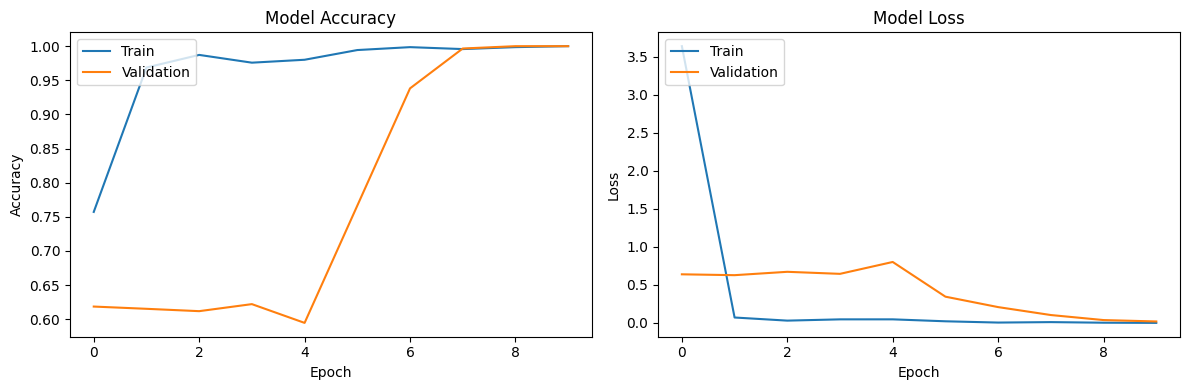

In [ ]:
# Plot training history
plot_history(history)

In [ ]:
# Save the model
model.save('shop_detection_model.h5')
print("Model saved as 'shop_detection_model.h5'")


Model saved as 'shop_detection_model.h5'
